## Simulator

In [1]:
import numpy as np
import pylab as plt
import torch
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import swyft
import random
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader



DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-12,1e-7), # omega alpha
                                                stats.uniform(0,3)], # alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [2]:
# Simluate data 
n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 



  0%|          | 0/10000 [00:00<?, ?it/s]

Visualize 

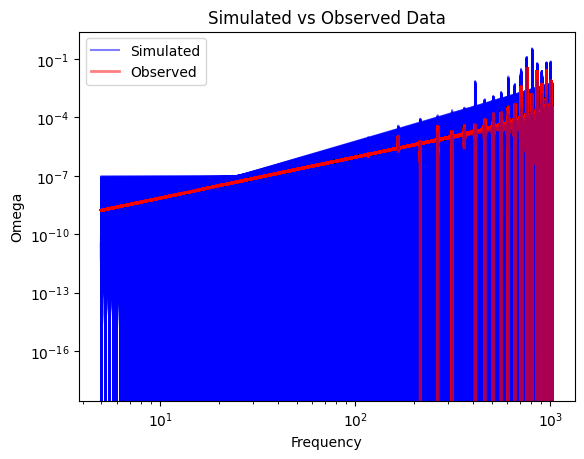

In [3]:

for i in range(len(samples)):
    if i == 0:  # Label only the first simulated dataset to avoid clutter
        plt.loglog(sim.freq, samples[i]['x'], 'b', alpha=0.5, label='Simulated')
        plt.loglog(sim.freq, obs['x'], 'r', lw=2,  alpha=0.5,label='Observed')  # Observed data
    else:
        plt.loglog(sim.freq, samples[i]['x'], 'b', alpha=0.5)
        plt.loglog(sim.freq, obs['x'], 'r', lw=2,  alpha=0.5)
        
# Adding labels and title
plt.xlabel("Frequency")
plt.ylabel("Omega")
plt.title("Simulated vs Observed Data")

# Show legend
plt.legend()
plt.show()


Plot variance of a random sample

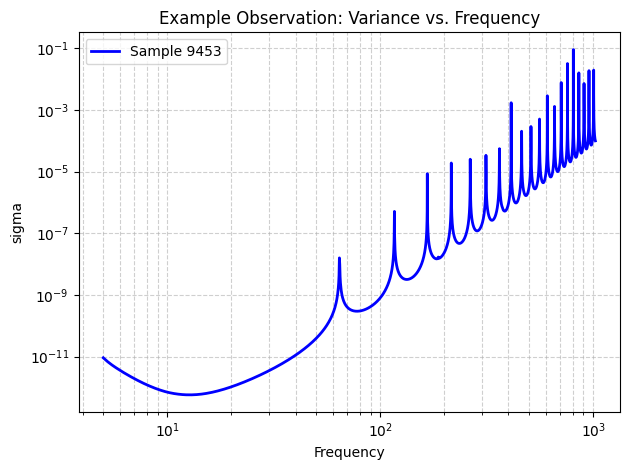

In [ ]:

# Select a random index from the available samples
random_index = random.randint(0, len(samples) - 1)

# Plot the randomly chosen sample
plt.loglog(sim.freq, samples[random_index]['sigma'], 'b', lw=2, label=f"Sample {random_index}")
plt.xlabel("Frequency")
plt.ylabel("sigma")
plt.title("Example Observation: Variance vs. Frequency")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()


Plot $ \Omega$ vs frequency for three random samples

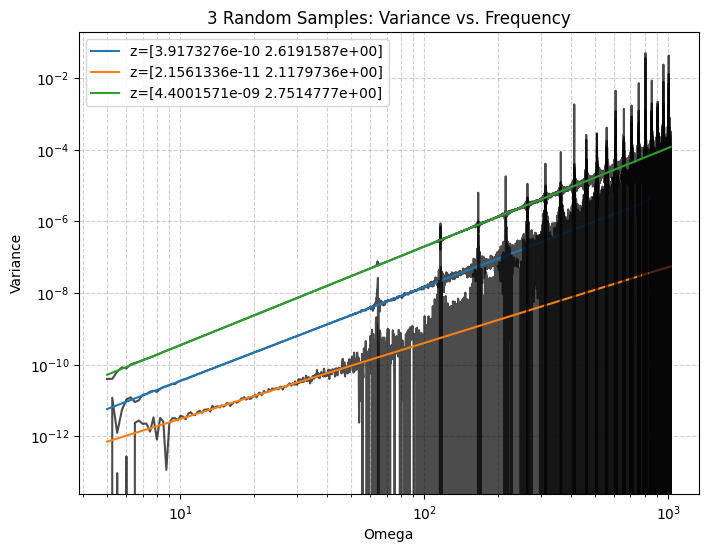

In [5]:

# Number of random samples to select
num_samples = 3  
random_indices = random.sample(range(len(samples)), num_samples)  # Select `num_samples` unique indices

plt.figure(figsize=(8, 6))

# Loop through the randomly selected indices
for i in random_indices:
    plt.loglog(sim.freq, samples[i]['x'], color='k', alpha=0.7)  # Slight transparency for clarity
    plt.loglog(sim.freq, samples[i]['m'], label=f"z={samples[i]['z']}")

# Labels, title, and grid
plt.xlabel("Omega")
plt.ylabel("Variance")
plt.title(f"{num_samples} Random Samples: Variance vs. Frequency")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.show()


In [6]:
#sim.freq

In [7]:
#samples['x']

## Variational Autoencoder

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4076, 1024)
        self.encoder_fc2 = nn.Linear(1024, 256)
        self.encoder_fc3 = nn.Linear(256, 64)

        # Latent space mean and log variance
        self.fc_mu = nn.Linear(64, 16) # bigger latent space improved learning 
        self.fc_logvar = nn.Linear(64, 16)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(16, 64)
        self.decoder_fc2 = nn.Linear(64, 256)
        self.decoder_fc3 = nn.Linear(256, 1024)
        self.decoder_fc4 = nn.Linear(1024, 4076)

        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        # Encode input to latent space
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        x = F.relu(self.encoder_fc3(x))

        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.relu(self.decoder_fc1(z))
        z = F.relu(self.decoder_fc2(z))
        z = F.relu(self.decoder_fc3(z))
        z = self.decoder_fc4(z)
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar



# Instantiate and print summary
model = VAE()
summary(model, input_size=(1, 4076))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]       4,174,848
            Linear-2               [-1, 1, 256]         262,400
            Linear-3                [-1, 1, 64]          16,448
            Linear-4                [-1, 1, 16]           1,040
            Linear-5                [-1, 1, 16]           1,040
           Dropout-6                [-1, 1, 16]               0
            Linear-7                [-1, 1, 64]           1,088
            Linear-8               [-1, 1, 256]          16,640
            Linear-9              [-1, 1, 1024]         263,168
           Linear-10              [-1, 1, 4076]       4,177,900
Total params: 8,914,572
Trainable params: 8,914,572
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 34.01
Estima

In [9]:
x_samples = np.log10(np.abs(samples['x']))
m_samples = np.log10(np.abs(samples['m']))

# First, split into train+val and test sets
x_train, x_temp, m_train, m_temp = train_test_split(x_samples, m_samples, test_size=0.2, random_state=42)

# Further split train+val into separate training and validation sets for 80/10/10 split
x_val, x_test, m_val, m_test = train_test_split(x_temp, m_temp, test_size=0.5, random_state=42)

# Scaling data across each sample (need to transpose first)
transposed_x_train = x_train.T
transposed_m_train = m_train.T
transposed_x_val = x_val.T
transposed_m_val = m_val.T
transposed_x_test = x_test.T
transposed_m_test = m_test.T

scaler_x = StandardScaler() 
scaler_m = StandardScaler()


x_T_scaled_train = scaler_x.fit_transform(transposed_x_train)
m_T_scaled_train = scaler_m.fit_transform(transposed_m_train)
x_T_scaled_val = scaler_x.fit_transform(transposed_x_val)
m_T_scaled_val = scaler_m.fit_transform(transposed_m_val)
x_T_scaled_test = scaler_x.fit_transform(transposed_x_test)
m_T_scaled_test = scaler_m.fit_transform(transposed_m_test)

x_scaled_train = x_T_scaled_train.T
m_scaled_train = m_T_scaled_train.T
x_scaled_val = x_T_scaled_val.T
m_scaled_val = m_T_scaled_val.T
x_scaled_test = x_T_scaled_test.T
m_scaled_test = m_T_scaled_test.T


# Convert to tensors
x_train_tensor = torch.tensor(x_scaled_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_scaled_test, dtype=torch.float32)
x_val_tensor = torch.tensor(x_scaled_val, dtype=torch.float32)
m_train_tensor = torch.tensor(m_scaled_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_scaled_test, dtype=torch.float32)
m_val_tensor = torch.tensor(m_scaled_val, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
val_dataset = TensorDataset(x_val_tensor, m_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [27]:
x_train_tensor.shape, x_val_tensor.shape, x_test_tensor.shape

(torch.Size([8000, 4076]), torch.Size([1000, 4076]), torch.Size([1000, 4076]))

In [11]:
"""
# Check that normalization worked
print("Min: ",np.min(x_scaled_test[0,:]))
print("Max: ",np.max(x_scaled_test[0,:]))
print("Mean: ",np.average(x_scaled_test[0,:]))
print("Var: ", np.var(x_scaled_test[0,:]))
"""

'\n# Check that normalization worked\nprint("Min: ",np.min(x_scaled_test[0,:]))\nprint("Max: ",np.max(x_scaled_test[0,:]))\nprint("Mean: ",np.average(x_scaled_test[0,:]))\nprint("Var: ", np.var(x_scaled_test[0,:]))\n'

In [12]:
"""
print("Min: ",np.min(x_scaled_train[0,:]))
print("Max: ",np.max(x_scaled_train[0,:]))
print("Mean: ",np.average(x_scaled_train[0,:]))

print("Var: ", np.var(x_scaled_train[0,:]))
"""

'\nprint("Min: ",np.min(x_scaled_train[0,:]))\nprint("Max: ",np.max(x_scaled_train[0,:]))\nprint("Mean: ",np.average(x_scaled_train[0,:]))\n\nprint("Var: ", np.var(x_scaled_train[0,:]))\n'

In [13]:
#x_scaled_train.shape, x_scaled_test.shape, x_scaled_val.shape

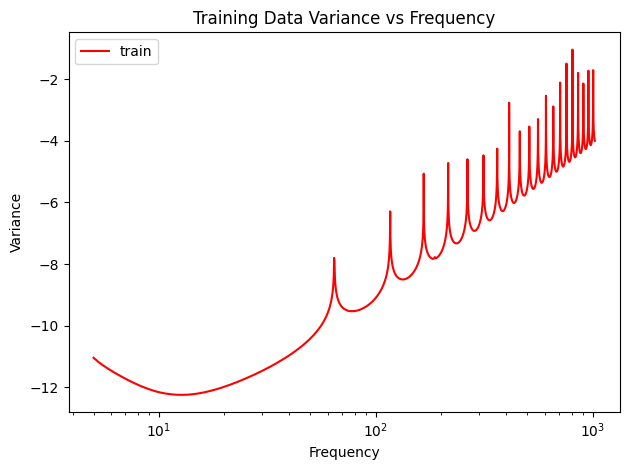

In [14]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = np.log10(sim.sigma())
sig_train = np.log10(sim.sigma())
sig_val = np.log10(sim.sigma())

plt.semilogx(sim.freq, sig_test, color = 'r', label = 'train')
#plt.loglog(sim.freq,sig_test, color = 'b', label = 'test')
#plt.loglog(sim.freq,sig_val, color = 'g', label = 'validate')

plt.ylabel("Variance")
plt.xlabel("Frequency")
plt.title("Training Data Variance vs Frequency")
plt.legend()
plt.tight_layout()

plt.show()


#plt.plot(sig_train, c="r")

In [15]:
#print(sig_train-sig_test)

In [16]:
#sig_train


In [17]:
# VAE Weighted Loss
def VAE_WeightedLoss(sigma, predictions, targets, mu, logvar):
    """
    Computes the total loss for a Variational Autoencoder (VAE), including:
    - Weighted Mean Squared Error (MSE) loss between predictions and targets.
    - Kullback-Leibler Divergence (KL divergence) to regularize the latent space.
    
    Args:
        sigma (list or torch.Tensor): The variance weights for each dimension.
        predictions (torch.Tensor): The reconstructed values from the VAE.
        targets (torch.Tensor): The target (original input) values.
        mu (torch.Tensor): The mean of the latent space distribution.
        logvar (torch.Tensor): The log variance of the latent space distribution.
        
    Returns:
        torch.Tensor: The total loss, combining weighted MSE loss and KL divergence.
    """
    #ensure sigma is a tensor if it is not already
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.Tensor(sigma)

    #ensure predictons and targets have same shape
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    # Weighted Mean Squared Error loss
    squared_error = 1 / sigma**2 * (predictions - targets)**2
    weighted_mse_loss = torch.mean(squared_error)

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: MSE + KL divergence
    total_loss = weighted_mse_loss + kl_divergence

    return total_loss


Epoch [1/100], Loss: 0.1234205431
Epoch [2/100], Loss: 0.0048013549
Epoch [3/100], Loss: 0.0034188058
Epoch [4/100], Loss: 0.0026874056
Epoch [5/100], Loss: 0.0020809271
Epoch [6/100], Loss: 0.0017884149
Epoch [7/100], Loss: 0.0014493611
Epoch [8/100], Loss: 0.0011780190
Epoch [9/100], Loss: 0.0010536720
Epoch [10/100], Loss: 0.0009504114
Epoch [11/100], Loss: 0.0008497109
Epoch [12/100], Loss: 0.0007778781
Epoch [13/100], Loss: 0.0006406055
Epoch [14/100], Loss: 0.0005648528
Epoch [15/100], Loss: 0.0005263405
Epoch [16/100], Loss: 0.0005542949
Epoch [17/100], Loss: 0.0004945600
Epoch [18/100], Loss: 0.0004155060
Epoch [19/100], Loss: 0.0003758771
Epoch [20/100], Loss: 0.0003472766
Epoch [21/100], Loss: 0.0003347440
Epoch [22/100], Loss: 0.0002983801
Epoch [23/100], Loss: 0.0002837222
Epoch [24/100], Loss: 0.0002598529
Epoch [25/100], Loss: 0.0002633818
Epoch [26/100], Loss: 0.0002444312
Epoch [27/100], Loss: 0.0002411499
Epoch [28/100], Loss: 0.0002367349
Epoch [29/100], Loss: 0.00019

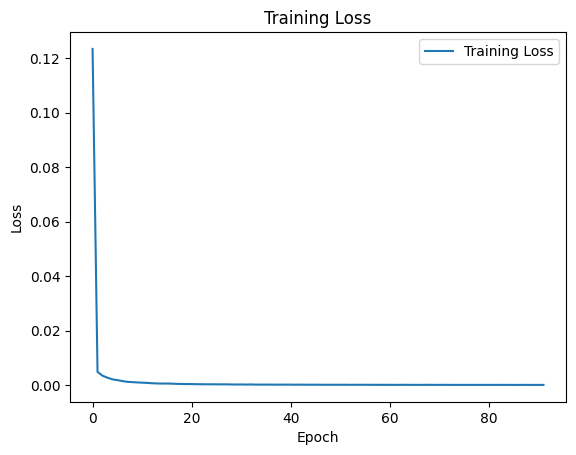

In [18]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Variational Autoencoder
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
  # list of variances per feature

# Define early stopping parameters
patience = 5 # Number of epochs to wait for improvement
best_loss = float('inf')  # Initial best loss, set to infinity
epochs_without_improvement = 0  # Counter for the number of epochs without improvement

train_losses = []
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass through the VAE
        outputs, mu, logvar = model(inputs.unsqueeze(1))  # Outputs, mu, logvar

        # Compute the loss
        loss = VAE_WeightedLoss(sig_train, outputs, targets.unsqueeze(1), mu, logvar)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")
    
    # Early stopping condition
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_without_improvement = 0  # Reset counter
    else:
        epochs_without_improvement += 1
        
    # Check if we've exceeded the patience
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} with no improvement for {patience} epochs.")
        break

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [19]:
torch.save(model,'VAE_model_pytorch_V2.pt')
model = torch.load('VAE_model_pytorch_V2.pt')

/var/folders/63/39kkwt414rv8gx91d72hdt240000gn/T/ipykernel_37159/1864736381.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('VAE_model_pytorch_V2.pt')

In [20]:
import random
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Ensure the model is in evaluation mode
model.eval()
test_loss = 0.0
test_predictions = []
test_targets_list = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, targets in test_loader:
        outputs, mu, logvar = model(inputs.unsqueeze(1))

        # Collect predictions and targets
        test_predictions.append(outputs.squeeze().numpy())
        test_targets_list.append(targets.numpy())

        # Calculate the weighted loss (if needed, but not necessary for plotting)
        loss = VAE_WeightedLoss(sig_test, outputs, targets.unsqueeze(1), mu, logvar)
        test_loss += loss.item() * inputs.size(0)

# Average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.3}")

# Convert predictions and targets to numpy arrays
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets_list, axis=0)



Test Loss: 0.000105


In [21]:
# Ensure the model is in evaluation mode
model.eval()
val_loss = 0.0
val_predictions = []
val_targets_list = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, targets in val_loader:
        outputs, mu, logvar = model(inputs.unsqueeze(1))

        # Collect predictions and targets
        val_predictions.append(outputs.squeeze().numpy())
        val_targets_list.append(targets.numpy())

        # Calculate the weighted loss (if needed, but not necessary for plotting)
        loss = VAE_WeightedLoss(sig_val, outputs, targets.unsqueeze(1), mu, logvar)
        val_loss += loss.item() * inputs.size(0)

# Average validation loss
val_loss /= len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.3}")

# Convert predictions and targets to numpy arrays
val_predictions = np.concatenate(val_predictions, axis=0)
val_targets = np.concatenate(val_targets_list, axis=0)


Validation Loss: 0.000106


In [22]:

test_size = np.int64(n_samples/10) # 10% test dataset

# Get means and sds from unscaled test dataset
target_means = np.mean(m_test, axis=1)
target_means = target_means.reshape(test_size,1)

target_sds = np.sqrt(np.var(m_test, axis=1))
target_sds = target_sds.reshape(test_size,1)

noisy_means = np.mean(x_test, axis=1)
noisy_means = target_means.reshape(test_size,1)

noisy_sds = np.sqrt(np.var(x_test, axis=1))
noisy_sds = target_sds.reshape(test_size,1)

# unscale the target dataset and predictions.
unscaled_targets = target_sds * test_targets + target_means
unscaled_predictions = noisy_sds * test_predictions + noisy_means # Use noisy means and sds

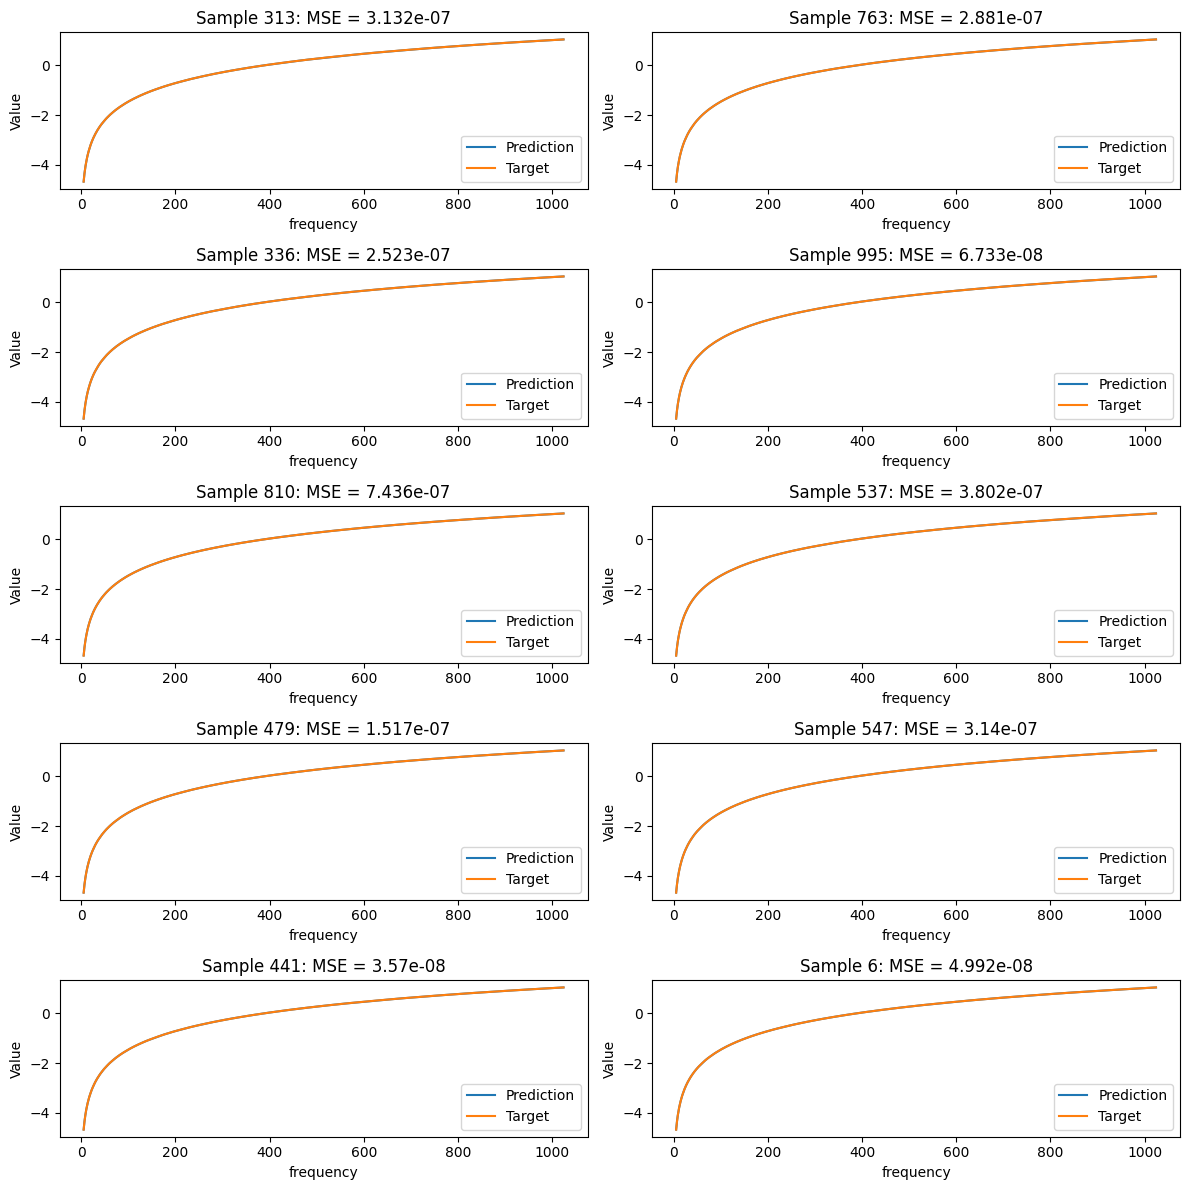

In [23]:
# Randomly select 10 indices
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 5
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    mse = F.mse_loss(prediction.squeeze(), target).item() # calculate error

    # Plot prediction and target
    axs[row, col].plot(sim.freq,prediction.squeeze().numpy(), label='Prediction')
    axs[row, col].plot(sim.freq,target.numpy(), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [24]:
#sim.freq

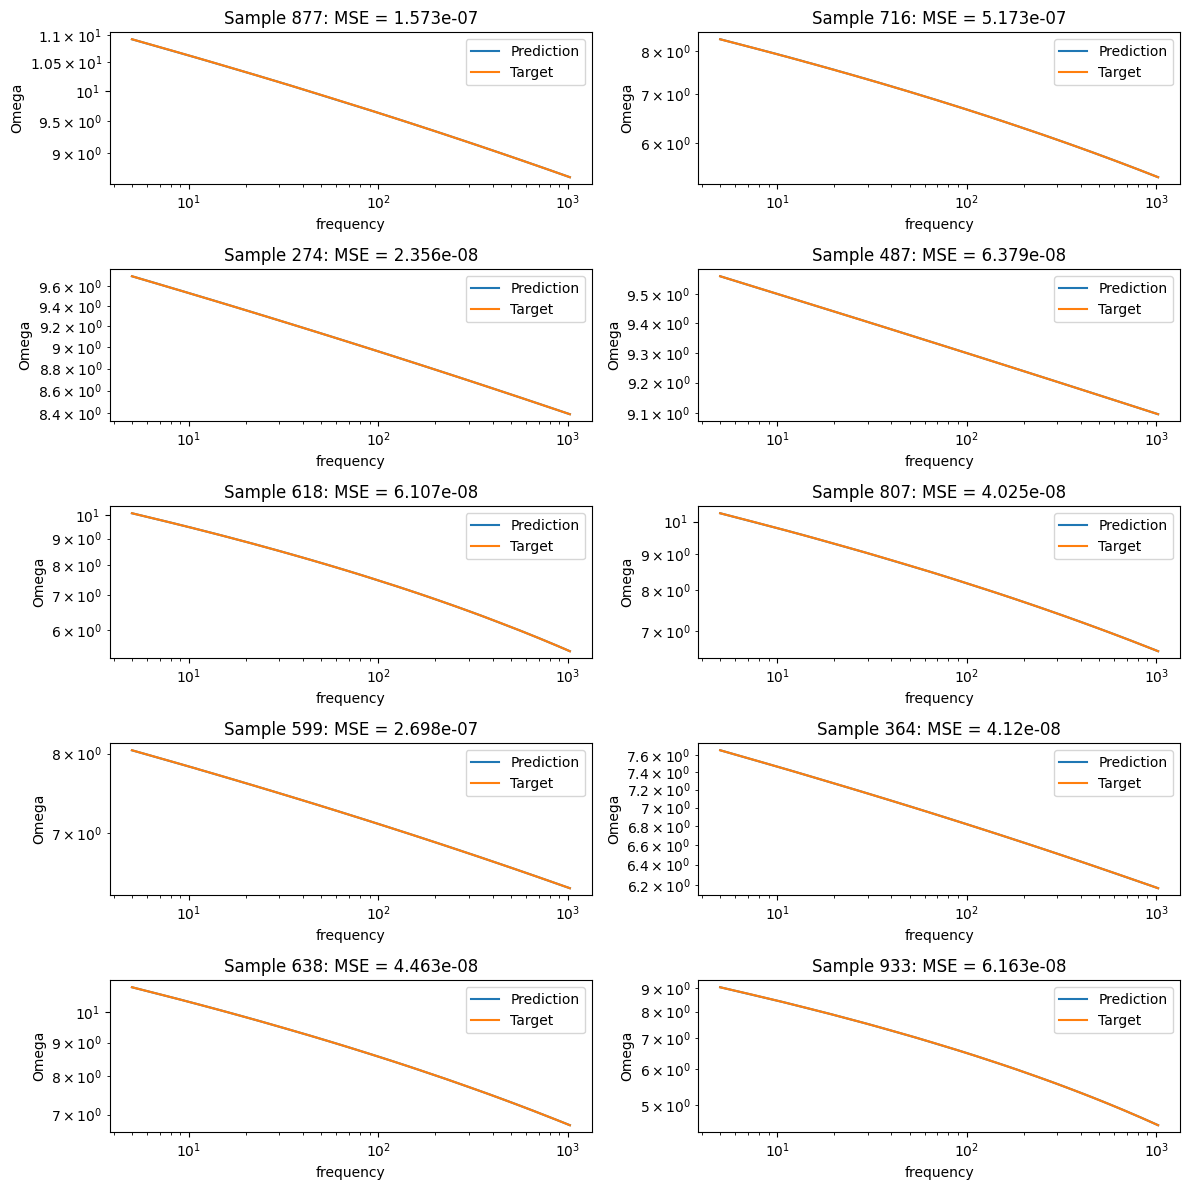

In [25]:
# Plotting scaled data 

# Randomly select 10 indices
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

# Set up the grid for subplots
num_rows = 5
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    # Extract the sample and corresponding target from test_dataset
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    # Get unscaled values for target and prediction
    target_sd = target_sds[idx]
    target_mean = target_means[idx]
    noisy_sd = noisy_sds[idx]
    noisy_mean = noisy_means[idx]
    
    unscaled_target = target_sd * target.numpy() + target_mean
    unscaled_prediction = noisy_sd * prediction.squeeze().numpy() + noisy_mean

    # Calculate Mean Squared Error between  target and  prediction
    mse = F.mse_loss(prediction.squeeze(), target).item() # calculate error

    # Plot unscaled prediction and unscaled target
    axs[row, col].loglog(sim.freq,np.abs(unscaled_prediction), label='Prediction')
    axs[row, col].loglog(sim.freq, np.abs(unscaled_target), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Omega')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

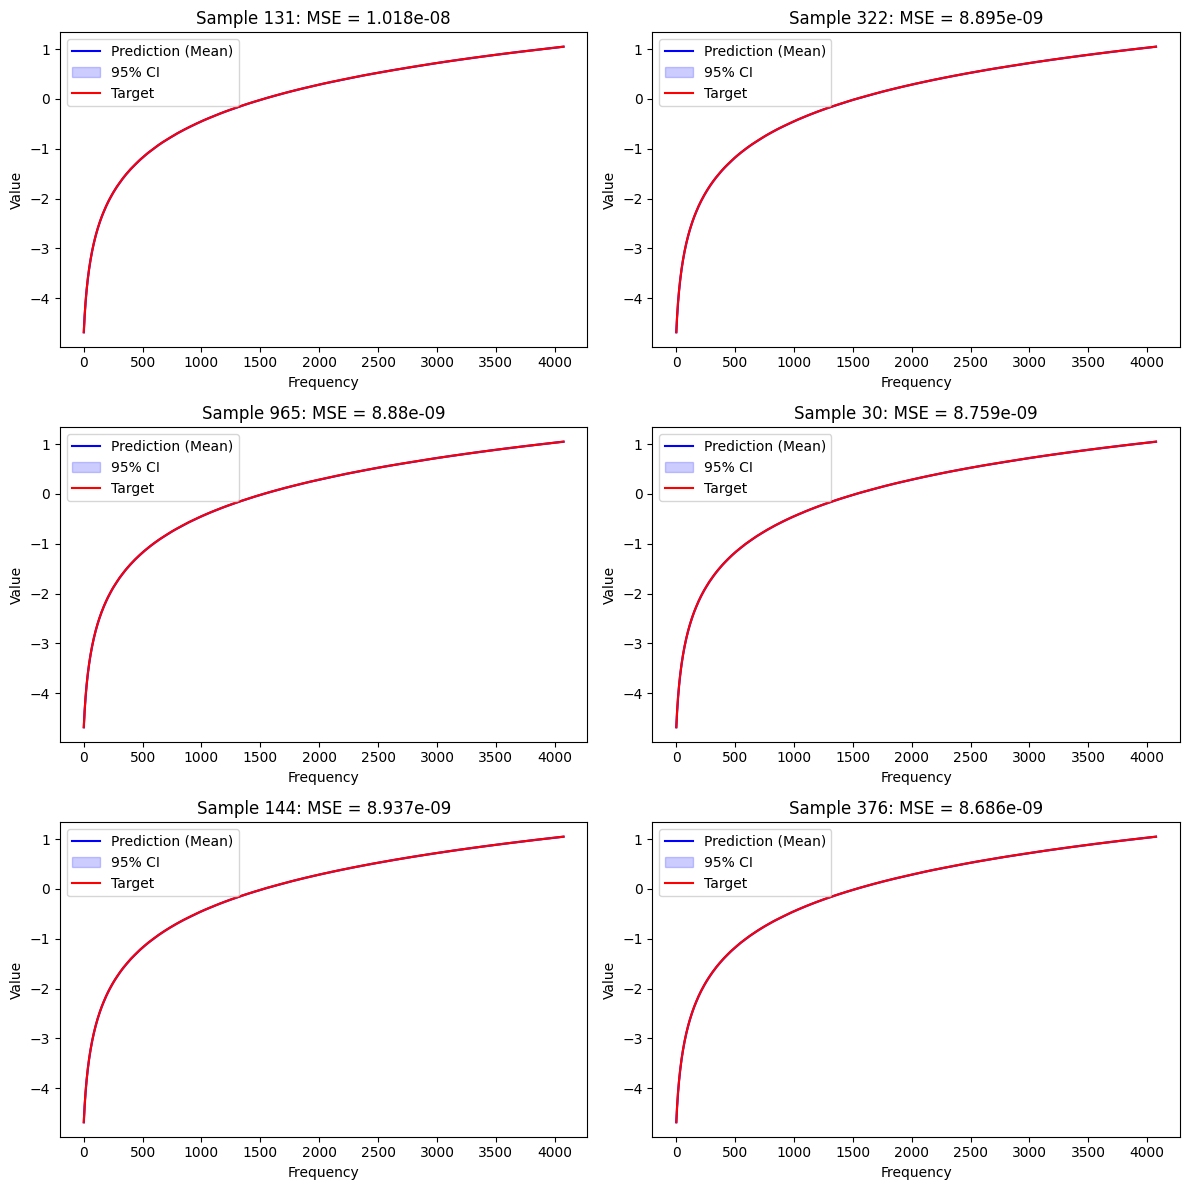

In [26]:
num_samples = 6
random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 3
num_cols = 2


fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]
    samples = []

    for _ in range(10000):  #simulate 10,000 model outputs
        with torch.no_grad():
            model.eval()
            prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0)) 
        samples.append(prediction.squeeze().numpy())  

    samples = np.array(samples)
    samples_mean = np.mean(samples, axis=0)
    samples_std = np.std(samples, axis=0)
     # 95% ci compute
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std

    # calculate mse for each sample
    mse = F.mse_loss(torch.tensor(samples_mean), target).item()

   
    # Plot prediction + target
    axs[row, col].plot(samples_mean, label='Prediction (Mean)', color='blue')
    axs[row, col].fill_between(range(len(samples_mean)), ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].plot(target.numpy(), label='Target', color='red')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4}')
    axs[row, col].legend()



# Hide empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()